<a href="https://colab.research.google.com/github/SicilianoBartolomeo/Human-activity-recognition/blob/main/HAR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from operator import imod
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as krs
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, Conv1D, Bidirectional, LSTM
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [4]:
import random
seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
from datetime import datetime


experiment_time = datetime.now().isoformat()
folder_name = str(experiment_time).replace(":","_")[0:19]
folder_name

configuration_file_name = 'configuration.txt'

In [13]:
dataset_path = 'DatasetUniba.csv'
columns_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

In [5]:
X_column_names = ['x_axis','y_axis','z_axis']
y_column_name = 'activity'

In [ ]:
falls = ['BackwardFall','ForwardFall','LeftFall','RightFall'] #uniba
#falls = ['BackwardFall', 'ForwardFall', 'LateralFall']  #umafall
#falls = ['Falls'] #unimibshar

In [6]:
classes_to_consider = ['lying','sitting','standing','walking','ironing']

In [7]:
classes_to_rename = {
     1:'lying',
     2:'sitting',
     3:'standing',
     4:'walking',
     5:'running',
     6: 'cycling',
     7:'Nordic walking',
     9: 'watching TV',
     10: 'computer work',
     11: 'car driving',
    12: 'ascending stairs',
    13: 'descending stairs',
    16:'vacuum cleaning',
    17:'ironing',
    18:'folding laundry',
    19:'house cleaning',
    20:'playing soccer',
    24:'rope jumping',
    0:'other'
}

In [8]:
time_steps_list = [600]
step_list =  [100]
use_magnitude = False
aggregate_falls = True
use_speed=True
use_total_speed=False
use_timestamp=False
use_squared_components=True
use_squared_speed=True
use_sign_speed=False
use_position=False

In [9]:
leave_one_subject_out = True
stratified_test_set = False
leave_one_subject_out_with_validation_users = False
bilstm_one_subject_out = True

use_stats_in_cnn=False

In [ ]:
save_features = False

In [10]:
batchsize = 512

In [11]:
from os import mkdir
mkdir(folder_name)

In [14]:
config_file = open(folder_name + "/" + configuration_file_name,"a")
config_file.write("dataset: " + dataset_path +
"time_steps_list: " + str(time_steps_list) + 
"\nstep_list:" + str(step_list)+
"\nuse_magnitude: "+str(use_magnitude)+
"\naggregate_falls: "+str(aggregate_falls)+
"\nuse_speed: "+str(use_speed)+
"\nuse_total_speed: "+str(use_total_speed)+
"\nuse_timestamp: "+str(use_timestamp)+
"\nuse_squared_components: "+str(use_squared_components)+
"\nuse_squared_speed: "+str(use_squared_speed)+
"\nuse_sign_speed: "+str(use_sign_speed)+
"\nuse_position: "+str(use_position)
)
config_file.close()

# Caricamento dati

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd gdrive/MyDrive

In [15]:
def load(dataset_path,id):
  columns=[]
  for i in range(54):
    columns.append(str(i))
  columns
  df = pd.read_csv(dataset_path, names=columns, delim_whitespace=True)
  df=df[['0','1','4','5','6']]
  df = df.rename({'0': 'timestamp', '1': 'activity', '4': 'x_axis',
                 '5': 'y_axis', '6': 'z_axis'}, axis=1) 
  df.insert(0, "user_id", id, True)
  return df

In [16]:
dataset_path = '/content/Dataset/subject10'
path = []

for i in range(4):
  if i != 0:
    path.append(dataset_path + str(i) + '.dat')

In [17]:
#load data subject by subject
column_names = ['user_id','timestamp', 'activity', 'x_axis','y_axis', 'z_axis']
df = pd.DataFrame(columns=column_names)
i=1
for x in path:
  #pd.concat(df, load(x,i))
  df = pd.concat([df, load(x,i)], ignore_index=True)
  i+=1


In [18]:
df = df.dropna()

In [19]:
df.isnull().sum()

user_id      0
timestamp    0
activity     0
x_axis       0
y_axis       0
z_axis       0
dtype: int64

In [ ]:
df = pd.read_csv(dataset_path, names=columns_names)

In [ ]:
df.head(10)

,user_id,timestamp,activity,x_axis,y_axis,z_axis
0,1,8.38,0,2.37223,8.60074,3.51048
1,1,8.39,0,2.18837,8.56560,3.66179
2,1,8.40,0,2.37357,8.60107,3.54898
3,1,8.41,0,2.07473,8.52853,3.66021
4,1,8.42,0,2.22936,8.83122,3.70000
5,1,8.43,0,2.29959,8.82929,3.54710
6,1,8.44,0,2.33738,8.82900,3.54767
7,1,8.45,0,2.37142,9.05500,3.39347
8,1,8.46,0,2.33951,9.13251,3.54668
9,1,8.47,0,2.25966,9.09415,3.43015


In [ ]:
df.sample(10)

,user_id,timestamp,activity,x_axis,y_axis,z_axis
1555520,5,1502.64,16,-11.223400,-4.51806,9.547550
672853,2,2970.00,4,NaN,NaN,NaN
2775474,8,3200.38,7,-6.228850,-16.16470,5.658970
2350342,7,2085.08,4,-9.156030,1.26493,0.437500
1662963,5,2577.07,0,4.228250,7.10195,7.238120
2110697,6,3306.77,5,14.039700,-1.17856,2.140250
664964,2,2891.11,4,-13.831000,2.09918,0.518608
625332,2,2494.79,12,-6.853480,2.14564,-0.878040
1010699,3,1878.46,12,0.863060,3.51858,2.427370
1823406,6,433.86,2,0.027328,8.59024,4.514550


In [ ]:
df.describe()

,user_id,timestamp,x_axis,y_axis,z_axis
count,970352.000000,970352.000000,970352.000000,970352.000000,970352.000000
mean,9.652475,7486.316867,0.406984,-0.656867,-0.275370
std,5.530966,4343.144385,4.259469,7.203429,4.695829
min,1.000000,0.000000,-56.221443,-61.331863,-58.738260
25%,5.000000,3730.000000,-2.204359,-3.413708,-3.185539
50%,9.000000,7460.000000,0.432485,-0.275161,-0.170318
75%,14.000000,11220.000000,2.824348,1.845646,1.931052
max,19.000000,15115.000000,57.871265,61.735350,52.757180


In [20]:
df['activity']=df['activity'].apply(lambda x: classes_to_rename[x] if x in classes_to_rename.keys() else x)

In [ ]:
if aggregate_falls:
    df['activity']=df['activity'].apply(lambda x: "Fall" if x in falls else x)

In [ ]:
#df = df[df['user_id']!=18]

In [21]:
df = df[df['activity'].isin(classes_to_consider)]
df.reset_index(drop=True, inplace=True)

In [22]:
df['activity'].unique()

array(['lying', 'sitting', 'standing', 'ironing', 'walking'], dtype=object)

In [ ]:
df['activity'].unique()

array(['lying', 'sitting', 'standing', 'walking'], dtype=object)

In [23]:
df.sample(10)

,user_id,timestamp,activity,x_axis,y_axis,z_axis
5092,1,88.58,lying,5.826050,5.065580,5.806400
284517,3,611.88,sitting,0.727601,8.400660,5.141470
79441,1,929.15,ironing,-3.037310,6.748650,8.015690
63103,1,669.12,standing,-8.382350,3.413750,3.790240
130854,2,188.84,lying,6.914770,2.707240,6.100080
168101,2,644.29,standing,-8.731590,4.407320,0.048383
187238,2,835.67,standing,-8.386150,4.974120,0.090132
351752,3,2183.08,walking,-10.326300,0.573047,-1.579040
163505,2,598.30,standing,-9.349900,2.524720,1.123120
193774,2,957.48,ironing,-2.568150,9.190030,1.433140


In [ ]:
if use_timestamp:
    df['ts']=df['timestamp']
    X_column_names.append('ts')

In [ ]:
import math

if use_magnitude:
    df['magnitude'] = np.sqrt(np.power(df['x_axis'],2) + np.power(df['y_axis'],2) + np.power(df['z_axis'],2))
    X_column_names.append('magnitude')
df.sample(10)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
80287,2,Walking,4560,-0.299662,-10.027537,0.869551
244360,6,Hopping,8665,-1.436161,0.074990,0.506077
68534,2,Jogging,1290,0.512122,-19.916449,1.170201
569240,15,Hopping,2560,1.413376,7.428269,0.282830
478365,12,Walking,1170,0.966936,7.791567,0.030316
428576,11,Hopping,8795,0.356096,-6.497741,-3.009370
572455,15,Hopping,3605,-4.072380,7.862972,0.074416
569350,15,Hopping,3110,-1.546647,0.218972,-0.908295
658129,17,Sitting,9390,0.297272,2.086763,-7.592010
97757,3,Fall,5275,-5.380082,-0.002115,5.534460


In [24]:
classes = df['activity'].unique()
classes

array(['lying', 'sitting', 'standing', 'ironing', 'walking'], dtype=object)

In [ ]:
classes = df['activity'].unique()
classes

array(['lying', 'sitting', 'standing', 'walking'], dtype=object)

In [ ]:
if use_speed:
    records = []

    for index, row in df.iterrows():
        record = dict()
        if index==0 or int(row['timestamp'])<int(df.iloc[index-1]['timestamp']):
            record['id']=index
            record['timestamp']=row['timestamp']
            record['v_x']=0
            record['v_y']=0
            record['v_z']=0
            record['x']=0
            record['y']=0
            record['z']=0
            record['v']=0
        else:
            prev_row = df.iloc[index-1]
            prev_record = records[-1]
            delta_t=(float(row['timestamp'])-float(prev_row['timestamp']))/1000
            record['id']=index
            record['timestamp']=row['timestamp']
            vx=float(prev_record['v_x'])+float(prev_row['x_axis'])*delta_t
            vy=float(prev_record['v_y'])+float(prev_row['y_axis'])*delta_t
            vz=float(prev_record['v_z'])+float(prev_row['z_axis'])*delta_t
            record['v_x']=vx
            record['v_y']=vy
            record['v_z']=vz
            x = float(prev_record['x']) + float(prev_record['v_x'])*delta_t + 0.5*float(prev_row['x_axis'])*(delta_t*delta_t)
            y = float(prev_record['x']) + float(prev_record['v_y'])*delta_t + 0.5*float(prev_row['y_axis'])*(delta_t*delta_t)
            z = float(prev_record['x']) + float(prev_record['v_z'])*delta_t + 0.5*float(prev_row['z_axis'])*(delta_t*delta_t)
            record['x']=x
            record['y']=y
            record['z']=z
            record['v']=np.sqrt(np.power(vx,2) + np.power(vy,2) + np.power(vz,2))
        records.append(record)

    df_velocità = pd.DataFrame(records, columns=['id','v_x','v_y','v_z','v','x','y','z'])
    df = pd.concat([df, df_velocità], axis=1).drop(columns=['id'])
    X_column_names+=['v_x','v_y','v_z','v']
    if not use_total_speed:
        X_column_names.remove('v')
    if use_position:
        X_column_names+=['x','y','z']
    df_velocità.head()

In [ ]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z
0,1,Fall,0,-2.120995,-7.684790,-0.116293,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,Fall,5,-1.837475,-7.524046,-0.273713,-0.010605,-0.038424,-0.000581,0.039865,-0.000027,-0.000096,-0.000001
2,1,Fall,10,-1.528029,-7.397976,-0.263592,-0.019792,-0.076044,-0.001950,0.078602,-0.000103,-0.000313,-0.000033
3,1,Fall,15,-1.099379,-7.245015,-0.243442,-0.027432,-0.113034,-0.003268,0.116361,-0.000221,-0.000575,-0.000116
4,1,Fall,20,-0.651752,-7.112909,-0.147084,-0.032929,-0.149259,-0.004485,0.152914,-0.000371,-0.000876,-0.000240


In [ ]:
if use_squared_components:
    df['x_axis_squared'] = np.square(df['x_axis'])
    df['y_axis_squared'] = np.square(df['y_axis'])
    df['z_axis_squared'] = np.square(df['z_axis'])
    X_column_names+=['x_axis_squared', 'y_axis_squared','z_axis_squared']

if use_squared_speed:
    df['vx2'] = np.square(df['v_x'])
    df['vy2'] = np.square(df['v_y'])
    df['vz2'] = np.square(df['v_z'])
    X_column_names+=['vx2','vy2','vz2']

if use_sign_speed:
    df['signvx']= np.sign(df['v_x'])  #df['v_x']/(np.abs(df['v_x'])+1)
    df['signvy']= np.sign(df['v_y'])  #df['v_y']/(np.abs(df['v_y'])+1)
    df['signvz']= np.sign(df['v_z'])  #df['v_z']/(np.abs(df['v_z'])+1)
    X_column_names+=['signvx','signvy','signvz']

In [25]:
users_ids = df['user_id'].unique()
users_number = len(users_ids)
print("Numero totale di utenti:",users_number)

Numero totale di utenti: 3


In [28]:
users_ids = df['user_id'].unique()
users_number = len(users_ids)
print("Numero totale di utenti:",users_number)

Numero totale di utenti: 3


In [29]:
user_original_data = dict() #dict {user_id: dataframe_dati_utente_originali}
for users_id in users_ids:
    user_original_data[users_id]=df[df['user_id']==users_id]

In [30]:
user_original_data.keys()

dict_keys([1, 2, 3])

In [31]:
user_original_data[1]

,user_id,timestamp,activity,x_axis,y_axis,z_axis
0,1,37.66,lying,2.21530,8.27915,5.58753
1,1,37.67,lying,2.29196,7.67288,5.74467
2,1,37.68,lying,2.29090,7.14240,5.82342
3,1,37.69,lying,2.21800,7.14365,5.89930
4,1,37.70,lying,2.30106,7.25857,6.09259
...,...,...,...,...,...,...
117486,1,2468.45,walking,2.59186,8.27589,5.55469
117487,1,2468.46,walking,2.77680,8.27343,5.44201
117488,1,2468.47,walking,2.70015,7.93290,5.48050
117489,1,2468.48,walking,2.80444,7.58889,5.29078


In [32]:
from scipy import stats
def create_sliding_windows(data, time_steps=1, step=1):
  Xs = []
  for i in range(0, len(data) - time_steps, step):
    v = data.iloc[i: (i+time_steps)]
    

    Xs.append(v)
    
  return Xs

In [33]:
user_trials = dict() #dict {user id: lista di trial dell'utente}

for users_id in users_ids:
    original_data = user_original_data[users_id]
    original_data.reset_index(inplace=True)
    #troviamo gli indici dei record iniziale di ogni trial (timestamp=0)
    index_start_trial = [0]
    for index, row in original_data.iterrows():
        if index==0:
            continue
        #if int(row['activity'])!=int(original_data.iloc[index-1]['activity']):
        if (row['activity'])!=(original_data.iloc[index-1]['activity']):
            print("ok")
            index_start_trial.append(index)
    trials = []
    for i in range(len(index_start_trial)-1):
        trials.append(original_data.iloc[index_start_trial[i]:index_start_trial[i+1]-1])
    trials.append(original_data.iloc[index_start_trial[len(index_start_trial)-1]:])
    user_trials[users_id]=trials

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


In [34]:
user_trials[3][2]

,index,user_id,timestamp,activity,x_axis,y_axis,z_axis
50805,300251,3,769.22,standing,-1.15553,9.53225,-1.47189
50806,300252,3,769.23,standing,-1.07781,9.64582,-1.43263
50807,300253,3,769.24,standing,-1.15045,9.87438,-1.39600
50808,300254,3,769.25,standing,-1.26890,9.72249,-1.51272
50809,300255,3,769.26,standing,-1.00036,9.91081,-1.43236
...,...,...,...,...,...,...,...
71323,320769,3,974.49,standing,-2.14776,3.94450,9.19310
71324,320770,3,974.50,standing,-1.99794,3.94300,9.15686
71325,320771,3,974.51,standing,-2.00276,4.20689,8.96346
71326,320772,3,974.52,standing,-1.96042,4.09413,9.11842


In [ ]:
user_trials[1][4]

,index,user_id,activity,timestamp,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
12084,12084,1,Hopping,0,0.588376,-12.244653,-3.510972,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.346186,149.931527,12.326926,0.000000,0.000000,0.000000
12085,12085,1,Hopping,5,1.688943,-12.206215,-2.763705,0.002942,-0.061223,-0.017555,0.063758,0.000007,-0.000153,-0.000044,2.852527,148.991685,7.638068,0.000009,0.003748,0.000308
12086,12086,1,Hopping,10,2.506947,-11.873831,-1.915576,0.011387,-0.122254,-0.031373,0.126728,0.000043,-0.000451,-0.000115,6.284786,140.987863,3.669431,0.000130,0.014946,0.000984
12087,12087,1,Hopping,15,2.959034,-11.462978,-1.201675,0.023921,-0.181623,-0.040951,0.187713,0.000131,-0.000717,-0.000138,8.755883,131.399865,1.444022,0.000572,0.032987,0.001677
12088,12088,1,Hopping,20,2.914835,-11.029402,-0.691599,0.038717,-0.238938,-0.046960,0.246568,0.000288,-0.000920,-0.000088,8.496264,121.647708,0.478309,0.001499,0.057092,0.002205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15079,15079,1,Hopping,14975,2.127361,-11.436087,-2.435742,-3.538412,-118.765564,-10.719030,119.300784,-26.787007,-27.362944,-26.822841,4.525665,130.784086,5.932839,12.520362,14105.259085,114.897597
15080,15080,1,Hopping,14980,1.024550,-10.493032,-2.617908,-3.527776,-118.822744,-10.731208,119.358487,-26.804673,-27.380978,-26.840633,1.049702,110.103710,6.853443,12.445200,14118.844488,115.158833
15081,15081,1,Hopping,14985,-0.181768,-9.692158,-2.784552,-3.522653,-118.875209,-10.744298,119.411743,-26.822299,-27.398918,-26.858362,0.033040,93.937927,7.753732,12.409083,14131.315348,115.439938
15082,15082,1,Hopping,14990,-1.502831,-9.059606,-2.907250,-3.523562,-118.923670,-10.758221,119.461266,-26.839915,-27.416796,-26.876055,2.258501,82.076461,8.452105,12.415486,14142.839270,115.739312


In [35]:
sliding_w_by_timestep=dict() #[timestep][steps][userid][indice trial][indice sliding window]

for time_steps in time_steps_list:
    sliding_w_by_step=dict()
    for step in step_list:
        user_sliding_windows = dict()  #[userid][indice trial][indice sliding window]
        for user_id in users_ids:
            user_trial_list = user_trials[user_id]
            num_trials = len(user_trial_list)  
            list_sliding_windows = []  
            for i in range(num_trials):
                trial = user_trial_list[i]
                sliding_window = create_sliding_windows(trial, time_steps, step)
                list_sliding_windows.append(sliding_window)
            user_sliding_windows[user_id]=list_sliding_windows    
        sliding_w_by_step[step]=user_sliding_windows
    sliding_w_by_timestep[time_steps]=sliding_w_by_step  

In [36]:
trial

,index,user_id,timestamp,activity,x_axis,y_axis,z_axis
99295,348741,3,2152.84,walking,0.014646,6.14490,6.831850
99296,348742,3,2152.85,walking,0.029343,6.71667,7.138040
99297,348743,3,2152.86,walking,-0.011391,6.86771,7.021460
99298,348744,3,2152.87,walking,-0.123693,7.02035,7.019260
99299,348745,3,2152.88,walking,0.067391,7.13304,7.060230
...,...,...,...,...,...,...,...
127860,377306,3,2443.15,walking,-1.201350,9.90925,-1.781750
127861,377307,3,2443.16,walking,-1.232180,9.94916,-1.589910
127862,377308,3,2443.17,walking,-1.341540,9.95104,-1.476090
127863,377309,3,2443.18,walking,-1.024510,9.95240,-1.047990


In [ ]:
#esempio di trial
trial

,index,user_id,activity,timestamp,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
33198,734724,19,Walking,0,3.905989,4.920188,3.792791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.256748,24.208250,14.385264,0.000000,0.000000,0.000000
33199,734725,19,Walking,5,3.712691,4.402665,1.453277,0.019530,0.024601,0.018964,0.036691,0.000049,0.000062,0.000047,13.784073,19.383459,2.112013,0.000381,0.000605,0.000360
33200,734726,19,Walking,10,3.388979,3.884667,-1.575216,0.038093,0.046614,0.026230,0.065666,0.000193,0.000227,0.000162,11.485179,15.090638,2.481306,0.001451,0.002173,0.000688
33201,734727,19,Walking,15,2.971400,3.394894,-3.453373,0.055038,0.066038,0.018354,0.087904,0.000426,0.000475,0.000304,8.829217,11.525303,11.925788,0.003029,0.004361,0.000337
33202,734728,19,Walking,20,2.431605,3.106119,-4.544110,0.069895,0.083012,0.001087,0.108524,0.000738,0.000798,0.000474,5.912702,9.647973,20.648938,0.004885,0.006891,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36204,737730,19,Walking,15030,3.607614,3.775315,-1.813403,17.134446,114.826340,5.423988,116.224341,131.738458,132.226920,131.679968,13.014877,14.253006,3.288430,293.589236,13185.088461,29.419648
36205,737731,19,Walking,15035,3.749106,4.399148,-2.120795,17.152484,114.845217,5.414921,116.245228,131.824176,132.312637,131.765556,14.055792,19.352508,4.497772,294.207706,13189.423874,29.321371
36206,737732,19,Walking,15040,3.862242,5.141159,-2.582244,17.171229,114.867213,5.404317,116.269232,131.909985,132.398457,131.851224,14.916911,26.431521,6.667985,294.851122,13194.476569,29.206644
36207,737733,19,Walking,15045,3.913796,6.209425,-3.008182,17.190541,114.892919,5.391406,116.296882,131.995889,132.484385,131.936974,15.317799,38.556964,9.049159,295.514690,13200.382737,29.067258


In [ ]:
sliding_w_by_timestep[time_steps_list[0]][step_list[0]][1][0][0]

,index,user_id,timestamp,activity,x_axis,y_axis,z_axis
0,0,1,37.66,lying,2.21530,8.27915,5.58753
1,1,1,37.67,lying,2.29196,7.67288,5.74467
2,2,1,37.68,lying,2.29090,7.14240,5.82342
3,3,1,37.69,lying,2.21800,7.14365,5.89930
4,4,1,37.70,lying,2.30106,7.25857,6.09259
...,...,...,...,...,...,...,...
595,595,1,43.61,lying,-2.43538,7.31994,4.55892
596,596,1,43.62,lying,-2.49064,7.55286,5.09613
597,597,1,43.63,lying,-2.62952,8.54179,5.24466
598,598,1,43.64,lying,-3.04547,8.69642,5.19942


In [ ]:
#esempio di sliding window
sliding_w_by_timestep[time_steps_list[0]][step_list[0]][1][0][0]

,index,user_id,activity,timestamp,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
0,0,1,Fall,0,-2.120995,-7.684790,-0.116293,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.498618,59.055997,0.013524,0.000000,0.000000,0.000000e+00
1,1,1,Fall,5,-1.837475,-7.524046,-0.273713,-0.010605,-0.038424,-0.000581,0.039865,-0.000027,-0.000096,-0.000001,3.376315,56.611268,0.074919,0.000112,0.001476,3.381020e-07
2,2,1,Fall,10,-1.528029,-7.397976,-0.263592,-0.019792,-0.076044,-0.001950,0.078602,-0.000103,-0.000313,-0.000033,2.334873,54.730049,0.069481,0.000392,0.005783,3.802614e-06
3,3,1,Fall,15,-1.099379,-7.245015,-0.243442,-0.027432,-0.113034,-0.003268,0.116361,-0.000221,-0.000575,-0.000116,1.208634,52.490242,0.059264,0.000753,0.012777,1.067976e-05
4,4,1,Fall,20,-0.651752,-7.112909,-0.147084,-0.032929,-0.149259,-0.004485,0.152914,-0.000371,-0.000876,-0.000240,0.424780,50.593479,0.021634,0.001084,0.022278,2.011704e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,595,1,Fall,2975,-2.325609,-0.509494,-6.871175,-5.930715,-2.537528,-12.896842,14.420158,-6.124823,-6.107881,-6.159599,5.408456,0.259584,47.213046,35.173386,6.439046,1.663285e+02
596,596,1,Fall,2980,-2.291714,-0.552084,-6.960178,-5.942344,-2.540075,-12.931197,14.456116,-6.154505,-6.137517,-6.189393,5.251955,0.304796,48.444083,35.311447,6.451981,1.672159e+02
597,597,1,Fall,2985,-2.234422,-0.602634,-7.031116,-5.953802,-2.542835,-12.965998,14.492442,-6.184246,-6.167212,-6.219248,4.992643,0.363168,49.436585,35.447759,6.466012,1.681171e+02
598,598,1,Fall,2990,-2.195272,-0.619144,-7.144061,-5.964974,-2.545849,-13.001154,14.529015,-6.214042,-6.196967,-6.249163,4.819220,0.383340,51.037602,35.580917,6.481345,1.690300e+02


In [37]:
df_aggregate_feature_by_timestep = dict()
axes = ['x_axis','y_axis','z_axis']

for time_steps in time_steps_list:
    df_aggregate_feature_by_step = dict()
    for step in step_list:
        df_aggregate_feature_by_user = []
        for user_id in users_ids:
            df_aggregate_feature_by_trial=dict()
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                df_aggregate_feature_by_sliding_window = dict()
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    tupla = dict()
                    tupla['time_steps']=time_steps
                    tupla['step']=step
                    tupla['user_id']=user_id
                    tupla['trial']=trial
                    tupla['sliding_window']=sliding_window
                    tupla['activity']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window]['activity'].unique()[0]
                    
                    for axis in axes:
                        tupla[f'{axis}_mean']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].mean()
                        tupla[f'{axis}_devstd']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].std()
                        tupla[f'{axis}_power']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].pow(2).mean()                   
                    
                    
                    for k1, v1 in sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axes].cov().to_dict().items():
                        for k2, v2 in v1.items():
                            tupla[f"cov({k1},{k2})"]=v2

                    df_aggregate_feature_by_user.append(tupla)
                    
                    #df_aggregate_feature_by_sliding_window[sliding_window]=tupla
                #df_aggregate_feature_by_trial[trial]=df_aggregate_feature_by_sliding_window
            #df_aggregate_feature_by_user[user_id]=df_aggregate_feature_by_trial
        df_aggregate_feature_by_step[step]=pd.DataFrame(df_aggregate_feature_by_user)
    df_aggregate_feature_by_timestep[time_steps]=df_aggregate_feature_by_step


In [38]:
df_aggregate_feature_by_timestep[time_steps_list[0]][step_list[0]]

,time_steps,step,user_id,trial,sliding_window,activity,x_axis_mean,x_axis_devstd,x_axis_power,y_axis_mean,...,z_axis_power,"cov(x_axis,x_axis)","cov(x_axis,y_axis)","cov(x_axis,z_axis)","cov(y_axis,x_axis)","cov(y_axis,y_axis)","cov(y_axis,z_axis)","cov(z_axis,x_axis)","cov(z_axis,y_axis)","cov(z_axis,z_axis)"
0,600,100,1,0,0,lying,-0.709646,1.667435,3.279302,8.295236,...,23.480369,2.780338,-1.347932,1.747684,-1.347932,2.489934,-2.163362,1.747684,-2.163362,3.646445
1,600,100,1,0,1,lying,-1.585988,1.058055,3.632974,8.437785,...,20.907345,1.119481,-0.577782,0.538822,-0.577782,2.240470,-1.835783,0.538822,-1.835783,3.069334
2,600,100,1,0,2,lying,-1.646930,1.220678,4.199951,8.531302,...,18.711301,1.490055,-0.330246,-0.347931,-0.330246,2.045023,-1.585414,-0.347931,-1.585414,3.324874
3,600,100,1,0,3,lying,-1.132143,1.775690,4.429566,8.560670,...,18.183457,3.153075,0.175823,-3.281736,0.175823,1.869958,-1.982305,-3.281736,-1.982305,8.573464
4,600,100,1,0,4,lying,-2.325163,3.583021,18.223029,7.162718,...,17.473563,12.838043,8.528038,-0.767829,8.528038,12.581744,0.558178,-0.767829,0.558178,9.637880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,600,100,3,4,275,walking,-8.732438,3.905722,91.484702,5.023723,...,15.225892,15.254662,7.497795,0.252518,7.497795,10.806588,3.104746,0.252518,3.104746,6.067390
3686,600,100,3,4,276,walking,-7.444213,3.967241,71.129077,5.546235,...,18.823103,15.739000,7.950792,-3.907871,7.950792,10.149481,1.409319,-3.907871,1.409319,16.044964
3687,600,100,3,4,277,walking,-6.161028,3.762165,52.088565,6.345533,...,21.272519,14.153885,7.208786,-5.471145,7.208786,8.794646,0.934888,-5.471145,0.934888,21.178984
3688,600,100,3,4,278,walking,-4.525000,3.088638,29.999413,7.235733,...,22.961493,9.539687,4.698627,-1.834417,4.698627,6.601956,2.227345,-1.834417,2.227345,22.687163


In [ ]:
df_aggregate_feature_by_timestep[time_steps_list[0]][step_list[0]]

,time_steps,step,user_id,trial,sliding_window,activity,x_axis_mean,x_axis_devstd,x_axis_power,y_axis_mean,...,z_axis_power,"cov(x_axis,x_axis)","cov(x_axis,y_axis)","cov(x_axis,z_axis)","cov(y_axis,x_axis)","cov(y_axis,y_axis)","cov(y_axis,z_axis)","cov(z_axis,x_axis)","cov(z_axis,y_axis)","cov(z_axis,z_axis)"
0,600,100,1,0,0,Fall,-1.995646,2.586167,10.659720,-0.850659,...,34.326067,6.688262,-11.273968,7.883962,-11.273968,48.027202,-11.912880,7.883962,-11.912880,15.362830
1,600,100,1,0,1,Fall,-2.506570,2.320661,11.659386,0.322977,...,42.615043,5.385467,-7.835804,6.440426,-7.835804,37.913874,-6.537518,6.440426,-6.537518,13.094506
2,600,100,1,0,2,Fall,-2.834991,2.154660,12.671999,1.210539,...,49.963273,4.642561,-5.478082,5.387755,-5.478082,30.079760,-2.515052,5.387755,-2.515052,11.709851
3,600,100,1,0,3,Fall,-2.681637,1.268671,8.798021,0.028316,...,48.912018,1.609527,0.448079,1.908640,0.448079,10.343486,3.942075,1.908640,3.942075,5.984117
4,600,100,1,0,4,Fall,-2.780770,0.637050,8.137838,-0.965211,...,55.097968,0.405833,0.181713,0.280007,0.181713,0.349389,0.280279,0.280007,0.280279,1.221111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6064,600,100,19,11,20,Walking,1.292207,3.456709,13.598721,7.433629,...,10.365817,11.948837,-12.156124,-3.774685,-12.156124,42.334281,0.577013,-3.774685,0.577013,10.344760
6065,600,100,19,11,21,Walking,1.014370,3.307303,11.948967,7.743142,...,8.668293,10.938251,-10.637709,-3.296705,-10.637709,35.119576,1.569864,-3.296705,1.569864,8.580417
6066,600,100,19,11,22,Walking,1.108906,3.723469,15.070783,7.590312,...,11.124517,13.864219,-10.310074,-4.555707,-10.310074,35.943224,1.771720,-4.555707,1.771720,11.067935
6067,600,100,19,11,23,Walking,1.058964,3.336957,12.238129,7.646630,...,8.024758,11.135283,-7.342637,-3.218866,-7.342637,24.065938,2.156671,-3.218866,2.156671,7.801633


In [39]:
import itertools

if save_features:
    for config in itertools.product(time_steps_list, step_list):
        time_step = config[0]
        step = config[1]
        
        example_list = []
        data = sliding_w_by_timestep[time_step][step]
        for user_id in users_ids:
            for trial in range(len(data[user_id])):
                for sliding_window in range(len(data[user_id][trial])):
                    for index, row in data[user_id][trial][sliding_window].iterrows():
                        item = row.to_dict()
                        item.update({'trial':trial,'sliding_window':sliding_window})
                        example_list.append(item)
        example_df = pd.DataFrame(example_list, columns=['trial','sliding_window']+list(sliding_w_by_timestep[time_step][step][users_ids[0]][0][0].columns))
        example_df.drop(columns="index", inplace=True)
        example_df.to_csv(f"{dataset_path.split('.')[0]}_{time_step}_{step}.csv")

NameError: ignored

In [40]:
tuple_by_timestep=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()

        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    Xs.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep[time_steps]=tuple_by_step        

In [41]:
ignore_columns = ['time_steps', 'step', 'user_id', 'trial', 'activity', 'sliding_window']

tuple_by_timestep_with_stats=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()
        actual_df_stats = df_aggregate_feature_by_timestep[time_steps][step]
        feature_columns = [col_name for col_name in list(actual_df_stats.columns.values) if not col_name in ignore_columns]
        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    raw_and_feature = np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]).flatten().reshape(-1,1)
                    actual_row_stats = actual_df_stats.loc[(actual_df_stats['time_steps']==time_steps) & (actual_df_stats['step']==step) & (actual_df_stats['user_id']==user_id) & (actual_df_stats['trial']==trial) &(actual_df_stats['sliding_window']==sliding_window)]
                    aggregate_feature = np.array(actual_row_stats[feature_columns]).reshape(-1,1)
                    #aggregate_feature = np.array(list(df_aggregate_feature_by_timestep[time_steps][step][user_id][trial][sliding_window].values())[2:]).reshape(-1,1)
                    Xs.append(np.concatenate((raw_and_feature,aggregate_feature),axis=0))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep_with_stats[time_steps]=tuple_by_step     

In [42]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives/ (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# CNN

In [43]:
cnn_dir = folder_name + "\\cnn"
leave_one_subject_out_dir = "\\leave_one_subject_out"
leave_one_subject_out_with_validation_user_dir =  "\\leave_one_subject_out_with_validation_user"
stratified_dir = "\\stratified"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

mkdir(cnn_dir )


In [44]:
def createCNN(input_size, output_size):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape = input_size))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy',f1_m])

    cnn_config_file = open(cnn_dir+config_filename, "a")
    model.summary(print_fn=lambda x: cnn_config_file.write(x))
    cnn_config_file.close()
    
    return model

In [45]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(np.array(classes).reshape(-1,1))

In [46]:
import gc
gc.collect()

227

In [47]:
if use_stats_in_cnn:
    data_cnn = tuple_by_timestep_with_stats
else:
    data_cnn = tuple_by_timestep

## CNN - Leave One Subject Out

In [48]:
for user_id in users_ids:

            print("Utente test: ", user_id)

            X_test = np.array(data_cnn[time_step][step][user_id][0])
            y_test = np.array(data_cnn[time_step][step][user_id][1])

            X_train = []
            y_train = []

            for id in users_ids:
                if not id == user_id:
                    X_train += data_cnn[time_step][step][id][0]
                    y_train += data_cnn[time_step][step][id][1]
            
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            print(X_train)
            print(y_train)

Utente test:  1


NameError: ignored

600 100
Utente test:  1
[[[[-0.3305315 ]
   [ 0.56437206]
   [-0.25671069]]

  [[-0.32668017]
   [ 0.58293834]
   [-0.27760877]]

  [[-0.34027599]
   [ 0.54495937]
   [-0.31275272]]

  ...

  [[-0.34319788]
   [ 0.53633843]
   [-0.24996599]]

  [[-0.32207677]
   [ 0.46049998]
   [-0.24228522]]

  [[-0.3354043 ]
   [ 0.50752559]
   [-0.27763416]]]


 [[[-0.32216769]
   [ 0.52644786]
   [-0.256415  ]]

  [[-0.3353145 ]
   [ 0.53585796]
   [-0.27770128]]

  [[-0.31365459]
   [ 0.53574594]
   [-0.25623178]]

  ...

  [[-0.33543349]
   [ 0.49808064]
   [-0.27761058]]

  [[-0.33417291]
   [ 0.47049759]
   [-0.21467509]]

  [[-0.3519815 ]
   [ 0.48917589]
   [-0.25704448]]]


 [[[-0.33092213]
   [ 0.53587041]
   [-0.27061372]]

  [[-0.31419451]
   [ 0.55430226]
   [-0.28421742]]

  [[-0.31365459]
   [ 0.53574594]
   [-0.25623178]]

  ...

  [[-0.33955534]
   [ 0.48879252]
   [-0.27070624]]

  [[-0.33047088]
   [ 0.48897923]
   [-0.24255914]]

  [[-0.33862478]
   [ 0.49873785]
   [-0.22881757]

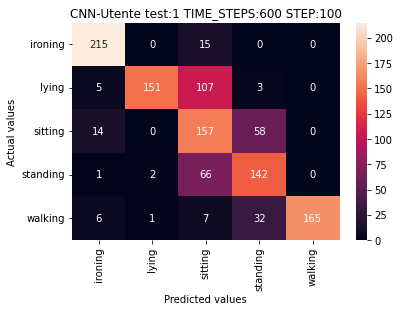

Utente test:  2
[[[[ 0.55177031]
   [ 0.81811422]
   [ 0.26080945]]

  [[ 0.5600816 ]
   [ 0.6847294 ]
   [ 0.30227655]]

  [[ 0.55996667]
   [ 0.56801906]
   [ 0.3230576 ]]

  ...

  [[ 0.026507  ]
   [ 0.87589736]
   [ 0.17033073]]

  [[-0.01858927]
   [ 0.90991734]
   [ 0.15839251]]

  [[-0.00310074]
   [ 0.90087058]
   [ 0.09805489]]]


 [[[ 0.4597477 ]
   [ 0.24578958]
   [ 0.55430122]]

  [[ 0.48615495]
   [ 0.43797618]
   [ 0.63573655]]

  [[ 0.4873432 ]
   [ 0.48857384]
   [ 0.7066692 ]]

  ...

  [[ 0.02357864]
   [ 0.86607396]
   [-0.03286177]]

  [[ 0.0073648 ]
   [ 0.87475111]
   [-0.02333283]]

  [[ 0.01951081]
   [ 0.8744849 ]
   [-0.03304385]]]


 [[[ 0.14469184]
   [ 0.97155064]
   [-0.18121868]]

  [[ 0.13208288]
   [ 0.79660614]
   [-0.16065665]]

  [[ 0.12946568]
   [ 0.76409322]
   [-0.04890078]]

  ...

  [[ 0.51200277]
   [ 0.9336035 ]
   [-1.12236411]]

  [[ 0.51670809]
   [ 1.02550344]
   [-1.10225201]]

  [[ 0.51295684]
   [ 1.1673916 ]
   [-1.11311911]]]


 ..

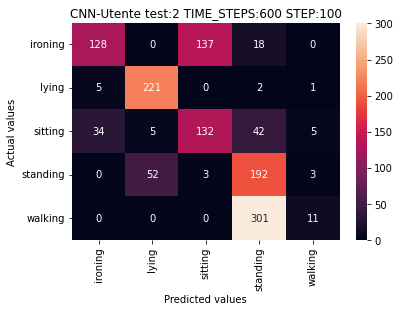

Utente test:  3
[[[[ 0.55713875]
   [ 0.8983604 ]
   [ 0.25278823]]

  [[ 0.56516274]
   [ 0.74731364]
   [ 0.2831095 ]]

  [[ 0.56505179]
   [ 0.61514927]
   [ 0.29830487]]

  ...

  [[ 0.05003219]
   [ 0.96379482]
   [ 0.18662904]]

  [[ 0.00649476]
   [ 1.0023195 ]
   [ 0.17789966]]

  [[ 0.0214479 ]
   [ 0.99207482]
   [ 0.13378003]]]


 [[[ 0.46829707]
   [ 0.25025226]
   [ 0.46739315]]

  [[ 0.49379151]
   [ 0.46788696]
   [ 0.5269397 ]]

  [[ 0.49493869]
   [ 0.52518443]
   [ 0.57880656]]

  ...

  [[ 0.04720505]
   [ 0.95267067]
   [ 0.0380521 ]]

  [[ 0.03155168]
   [ 0.96249679]
   [ 0.04501978]]

  [[ 0.04327784]
   [ 0.96219533]
   [ 0.03791896]]]


 [[[ 0.16413174]
   [ 1.07211389]
   [-0.07042836]]

  [[ 0.15195863]
   [ 0.87400437]
   [-0.05539315]]

  [[ 0.1494319 ]
   [ 0.8371863 ]
   [ 0.02632417]]

  ...

  [[ 0.51874585]
   [ 1.02914203]
   [-0.75860589]]

  [[ 0.52328852]
   [ 1.13321076]
   [-0.74389966]]

  [[ 0.51966694]
   [ 1.29388683]
   [-0.75184583]]]


 ..

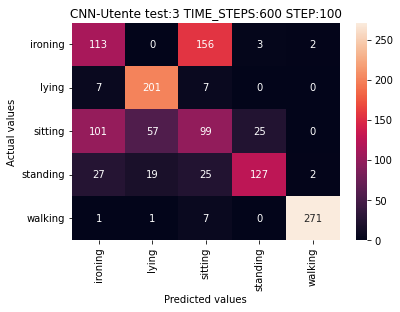

Accuracy media: 0.6337733307550243
F1 weighted media: 0.6199653479701235
F1 macro media: 0.6328651904950299
   Time Steps  Step  Average accuracy  Average F1 Weighted  Average F1 Macro  \
0         600   100          0.633773             0.619965          0.632865   

                                             reports  \
0  [              precision    recall  f1-score  ...   

                                    confusion_matrix  
0  [AxesSubplot(0.125,0.125;0.62x0.755), AxesSubp...  


In [49]:
import itertools
import gc
from tabnanny import verbose
from tkinter import Y
batchsize=128

if leave_one_subject_out:
    cnn_results_dict = []
    cnn_results = pd.DataFrame()
    try:
        mkdir(cnn_dir + leave_one_subject_out_dir)
        mkdir(cnn_dir + leave_one_subject_out_dir + plot_dir)
    except OSError as error:
        print(error)

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        cnn_f1_macro = []
        cnn_f1_weighted = []
        cnn_acc = []
        cnn_class_reports = []
        cnn_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:

            print("Utente test: ", user_id)

            X_test = np.array(data_cnn[time_step][step][user_id][0])
            y_test = np.array(data_cnn[time_step][step][user_id][1])

            X_train = []
            y_train = []

            for id in users_ids:
                if not id == user_id:
                    X_train += data_cnn[time_step][step][id][0]
                    y_train += data_cnn[time_step][step][id][1]
            
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            scaler = RobustScaler()
            X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
            X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

            y_train = enc.transform(y_train)
            y_test = enc.transform(y_test)

            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

            print(X_train)
            print(y_train)
            print(X_test)

            print(y_test)

            model = createCNN(X_train[0].shape, y_train[0].shape[0])

            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

            XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

            print("Training: x->",len(XTraining),"y->",len(YTraining))
            print("Validation: x->",len(XValidation),"y->",len(YValidation))
            print("Testing: x->",len(X_test),"y->",len(y_test))
            print("Total: x->",len(XTraining)+len(XValidation)+len(X_test),"y->",len(YTraining)+len(YValidation)+len(y_test))

            model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True, workers=10, use_multiprocessing=True )

            rounded_labels=np.argmax(y_test, axis=1)
            y_pred = np.argmax(model.predict(X_test), axis=-1)

            cnn_acc.append(accuracy_score(rounded_labels, y_pred))
            cnn_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
            cnn_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #cnn_f1.append(f1_m(rounded_labels,y_pred))

            class_report = classification_report(rounded_labels, y_pred, digits=4)
            print(class_report)
            cnn_class_reports.append(class_report)
            
            conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

            ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

            ax.set_title("CNN-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

            ax.set_xlabel('Predicted values')
            ax.set_ylabel('Actual values')

            ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
            ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

            ax.get_figure().savefig(cnn_dir + leave_one_subject_out_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
            #model_history_file=open(cnn_dir+'/'+ax.get_title().replace(":"," ")+".txt", "w")
            #model_history_file.write(model.history())
            #model_history_file.close()

            cnn_confusion_matrixes.append(ax)
            plt.show()

            gc.collect()            

        print("Accuracy media:",np.mean(cnn_acc))
        print("F1 weighted media:",np.mean(cnn_f1_weighted))
        print("F1 macro media:",np.mean(cnn_f1_macro))

        cnn_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(cnn_acc),
            'Average F1 Weighted': np.mean(cnn_f1_weighted),
            'Average F1 Macro': np.mean(cnn_f1_macro),
            'reports':cnn_class_reports,
            'confusion_matrix':cnn_confusion_matrixes
        })
        
        cnn_results = pd.DataFrame(cnn_results_dict)
        print(cnn_results)
        cnn_results.to_csv(cnn_dir + leave_one_subject_out_dir + result_filename)


In [ ]:
print(np.unique(y_pred))
print(np.unique(y_test))

[0 1 2 3 4 5 7]
[0.]


# Bi-LSTM

In [50]:
bilstm_dir = folder_name + "\\bilstm"
bilstm_plot_dir = bilstm_dir + "\\plot"
bilstm_result_filename = bilstm_dir + "\\result.csv"
bilstm_config_filename = bilstm_dir + "\\config_bilstm.txt"

mkdir(bilstm_dir)
mkdir(bilstm_plot_dir)

In [51]:
def createBiLSTM(input_size, output_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=input_size)))
    model.add(Dropout(rate=0.2))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dropout(rate=0.2))

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(output_size, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    
    return model

In [52]:
data_cnn = tuple_by_timestep

600 100
Utente test:  1
Epoch 1/100
16/16 [==============================] - 10s 214ms/step - loss: 1.2420 - accuracy: 0.5044 - val_loss: 0.7803 - val_accuracy: 0.5953
Epoch 2/100
16/16 [==============================] - 2s 119ms/step - loss: 0.8000 - accuracy: 0.6249 - val_loss: 0.6091 - val_accuracy: 0.7308
Epoch 3/100
16/16 [==============================] - 2s 120ms/step - loss: 0.6858 - accuracy: 0.7237 - val_loss: 0.5140 - val_accuracy: 0.7976
Epoch 4/100
16/16 [==============================] - 2s 119ms/step - loss: 0.5313 - accuracy: 0.8063 - val_loss: 0.3814 - val_accuracy: 0.8625
Epoch 5/100
16/16 [==============================] - 2s 119ms/step - loss: 0.5178 - accuracy: 0.8333 - val_loss: 0.3870 - val_accuracy: 0.8664
Epoch 6/100
16/16 [==============================] - 2s 120ms/step - loss: 0.5197 - accuracy: 0.8240 - val_loss: 0.3721 - val_accuracy: 0.8821
Epoch 7/100
16/16 [==============================] - 2s 120ms/step - loss: 0.4320 - accuracy: 0.8687 - val_loss: 0.48

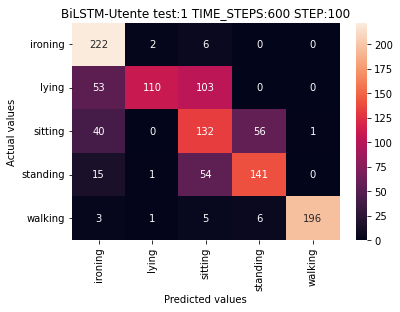

Utente test:  2
Epoch 1/100
15/15 [==============================] - 9s 216ms/step - loss: 1.3236 - accuracy: 0.4656 - val_loss: 0.9969 - val_accuracy: 0.5958
Epoch 2/100
15/15 [==============================] - 2s 120ms/step - loss: 0.9787 - accuracy: 0.6011 - val_loss: 0.7985 - val_accuracy: 0.7146
Epoch 3/100
15/15 [==============================] - 2s 121ms/step - loss: 0.8293 - accuracy: 0.6882 - val_loss: 0.6527 - val_accuracy: 0.7812
Epoch 4/100
15/15 [==============================] - 2s 122ms/step - loss: 0.7243 - accuracy: 0.7367 - val_loss: 0.5822 - val_accuracy: 0.8167
Epoch 5/100
15/15 [==============================] - 2s 121ms/step - loss: 0.6537 - accuracy: 0.7758 - val_loss: 0.4925 - val_accuracy: 0.8583
Epoch 6/100
15/15 [==============================] - 2s 121ms/step - loss: 0.5781 - accuracy: 0.8102 - val_loss: 0.4775 - val_accuracy: 0.8354
Epoch 7/100
15/15 [==============================] - 2s 119ms/step - loss: 0.5083 - accuracy: 0.8279 - val_loss: 0.3925 - val_

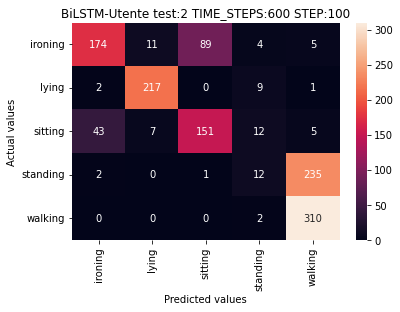

Utente test:  3
Epoch 1/100
16/16 [==============================] - 9s 208ms/step - loss: 1.2869 - accuracy: 0.5161 - val_loss: 0.9010 - val_accuracy: 0.6434
Epoch 2/100
16/16 [==============================] - 2s 119ms/step - loss: 0.8155 - accuracy: 0.6694 - val_loss: 0.7238 - val_accuracy: 0.6762
Epoch 3/100
16/16 [==============================] - 2s 121ms/step - loss: 0.6948 - accuracy: 0.7468 - val_loss: 0.6225 - val_accuracy: 0.8033
Epoch 4/100
16/16 [==============================] - 2s 126ms/step - loss: 0.6104 - accuracy: 0.7945 - val_loss: 0.5032 - val_accuracy: 0.8156
Epoch 5/100
16/16 [==============================] - 3s 174ms/step - loss: 0.5210 - accuracy: 0.8232 - val_loss: 0.4459 - val_accuracy: 0.8545
Epoch 6/100
16/16 [==============================] - 2s 139ms/step - loss: 0.5265 - accuracy: 0.8098 - val_loss: 0.4627 - val_accuracy: 0.8320
Epoch 7/100
16/16 [==============================] - 2s 122ms/step - loss: 0.5152 - accuracy: 0.8242 - val_loss: 0.4020 - val_

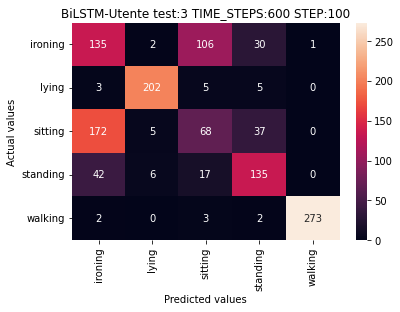

Accuracy media: 0.6723180836243926
F1 media macro: 0.6591735848458623
F1 media weighted: 0.6591735848458623


In [53]:
import itertools
import gc
bilstm_results_dict = []
bilstm_results = pd.DataFrame()

if bilstm_one_subject_out:

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        bilstm_f1_weighted = []
        bilstm_f1_macro = []
        bilstm_acc = []
        bilstm_class_reports = []
        bilstm_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:

            print("Utente test: ", user_id)

            X_test = np.array(data_cnn[time_step][step][user_id][0])
            y_test = np.array(data_cnn[time_step][step][user_id][1])

            X_train = []
            y_train = []

            for id in users_ids:
                if id != user_id:
                    X_train += data_cnn[time_step][step][id][0]
                    y_train += data_cnn[time_step][step][id][1]
            
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            y_train = enc.transform(y_train)
            y_test = enc.transform(y_test)

            scaler = RobustScaler()
            X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
            X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
            
            #X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
            #X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

            model = createBiLSTM([X_train[0].shape[0], X_train[0].shape[1]], y_train[0].shape[0])

            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True, restore_best_weights=True)

            XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

            model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True )
            
            rounded_labels=np.argmax(y_test, axis=1)
            y_pred = np.argmax(model.predict(X_test), axis=-1)

            bilstm_acc.append(accuracy_score(rounded_labels, y_pred))
            bilstm_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
            bilstm_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #bilstm_f1.append(f1_m(rounded_labels,y_pred))

            class_report = classification_report(rounded_labels, y_pred, digits=4)
            print(class_report)
            bilstm_class_reports.append(class_report)
            
            conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

            ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

            ax.set_title("BiLSTM-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

            ax.set_xlabel('Predicted values')
            ax.set_ylabel('Actual values')

            ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
            ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

            ax.get_figure().savefig(bilstm_plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)

            bilstm_confusion_matrixes.append(ax)
            plt.show()

            gc.collect()





            

        print("Accuracy media:",np.mean(bilstm_acc))
        print("F1 media macro:",np.mean(bilstm_f1_macro))
        print("F1 media weighted:",np.mean(bilstm_f1_macro))

        bilstm_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(bilstm_acc),
            'Average F1 weighted': np.mean(bilstm_f1_weighted),
            'Average F1 macro': np.mean(bilstm_f1_macro),
            'reports':bilstm_class_reports,
            'confusion_matrix':bilstm_confusion_matrixes
        })

    bilstm_config_file = open(bilstm_config_filename, "a")
    model.summary(print_fn=lambda x: bilstm_config_file.write(x))
    bilstm_config_file.close()

In [54]:
bilstm_results_dataframe = pd.DataFrame(bilstm_results_dict)
bilstm_results_dataframe.to_csv(bilstm_result_filename)
bilstm_results_dataframe

,Time Steps,Step,Average accuracy,Average F1 weighted,Average F1 macro,reports,confusion_matrix
0,600,100,0.672318,0.652064,0.659174,[ precision recall f1-score ...,"[AxesSubplot(0.125,0.125;0.62x0.755), AxesSubp..."


# SHALLOW LEARNING

## Random Forest

In [55]:
rf_dir = folder_name + "\\rf"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

try:
    mkdir(rf_dir )
    mkdir(rf_dir + plot_dir)
except OSError as error:
    print(error)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   39.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.4s finished


              precision    recall  f1-score   support

     ironing       0.54      1.00      0.70       230
       lying       1.00      0.37      0.54       266
     sitting       0.49      0.52      0.50       229
    standing       0.69      0.62      0.65       211
     walking       1.00      0.91      0.96       211

    accuracy                           0.67      1147
   macro avg       0.74      0.68      0.67      1147
weighted avg       0.75      0.67      0.66      1147

f1:  0.6619213761295732
acc:  0.6713164777680907


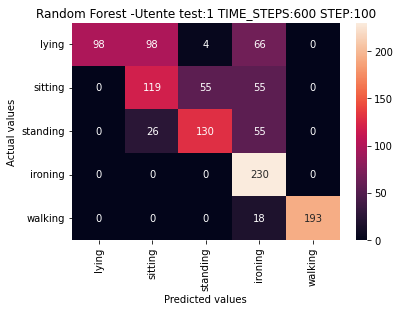

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   38.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.4s finished


              precision    recall  f1-score   support

     ironing       0.84      0.90      0.87       283
       lying       0.99      0.94      0.96       229
     sitting       0.92      0.73      0.82       218
    standing       0.90      0.94      0.92       250
     walking       0.93      1.00      0.96       312

    accuracy                           0.91      1292
   macro avg       0.91      0.90      0.90      1292
weighted avg       0.91      0.91      0.91      1292

f1:  0.9078023165957603
acc:  0.9094427244582043


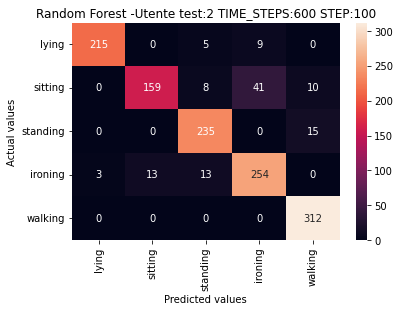

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   38.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.5s finished


              precision    recall  f1-score   support

     ironing       0.38      0.47      0.42       274
       lying       0.91      0.94      0.92       215
     sitting       0.26      0.34      0.29       282
    standing       0.48      0.07      0.13       200
     walking       0.95      0.97      0.96       280

    accuracy                           0.57      1251
   macro avg       0.60      0.56      0.55      1251
weighted avg       0.59      0.57      0.55      1251

f1:  0.5539387339551908
acc:  0.5715427657873701


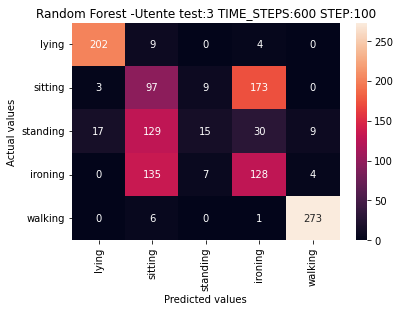

F1 total:  0.7078874755601747
Accuracy total:  0.7174339893378883
   Time Steps  Step  Average accuracy  Average F1
0         600   100          0.717434    0.707887


In [56]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

rf_results = []

gc.collect()
for config in itertools.product(time_steps_list, step_list):



    time_step = config[0]
    step=config[1]

    tuple = tuple_by_timestep[time_steps][step]

    f1_list = []
    acc_list = []

    for user_id in users_ids:

        x_test = tuple[user_id][0]
        y_test = tuple[user_id][1]

        x_train = []
        y_train = []

        for id in users_ids:
            if id != user_id:
                x_train+=tuple[id][0]
                y_train+=tuple[id][1]
        
        x_train = [x_train[i].flatten() for i in range(len(x_train)) ]
        x_test = [x_test[i].flatten() for i in range(len(x_test))]

        y_train = np.array(y_train).flatten()
        y_test = np.array(y_test).flatten()

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        model = RandomForestClassifier(n_jobs=-1,n_estimators=1000,random_state=seed, verbose=True)

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        conf_mat = confusion_matrix(y_test, y_pred, labels=classes)

        f1 = f1_score(y_test, y_pred, average='weighted')
        acc = accuracy_score(y_test, y_pred)

        print(classification_report(y_test, y_pred))

        ax = seaborn.heatmap(conf_mat, annot=True, fmt='d')

        ax.set_title("Random Forest -Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))
        ax.get_figure().savefig(rf_dir+plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual values')

        ax.xaxis.set_ticklabels(classes, rotation=90)
        ax.yaxis.set_ticklabels(classes, rotation=0)


        print("f1: ", f1)
        print("acc: ", acc)

        f1_list.append(f1)
        acc_list.append(acc)


        plt.show()
    
    print("F1 total: ", np.mean(f1_list))
    print("Accuracy total: ", np.mean(acc_list))

    rf_results.append({
    'Time Steps':time_step,
    'Step':step,
    'Average accuracy':np.mean(acc_list),
    'Average F1': np.mean(f1_list),
    })

rf_results_df = pd.DataFrame(rf_results)
rf_results_df.to_csv(rf_dir + result_filename)
print(rf_results_df)


## SVM

In [61]:
svm_dir = folder_name + "\\svm"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

try:
    mkdir(svm_dir )
    mkdir(svm_dir + plot_dir)
except OSError as error:
    print(error)

[Errno 17] File exists: '2022-11-27T14_42_29\\svm'


[LibSVM]              precision    recall  f1-score   support

     ironing       0.51      0.55      0.53       230
       lying       0.96      0.73      0.82       266
     sitting       0.37      0.63      0.47       229
    standing       0.49      0.50      0.50       211
     walking       1.00      0.44      0.61       211

    accuracy                           0.58      1147
   macro avg       0.67      0.57      0.59      1147
weighted avg       0.67      0.58      0.59      1147

f1 macro:  0.5855587746318757
f1 weighted:  0.5942121854321516
acc:  0.5771578029642546


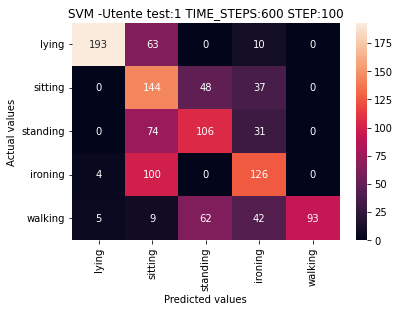

[LibSVM]              precision    recall  f1-score   support

     ironing       0.60      0.22      0.32       283
       lying       0.80      0.93      0.86       229
     sitting       0.49      0.70      0.58       218
    standing       0.26      0.08      0.12       250
     walking       0.56      0.96      0.70       312

    accuracy                           0.58      1292
   macro avg       0.54      0.58      0.52      1292
weighted avg       0.54      0.58      0.51      1292

f1 macro:  0.5161949140213411
f1 weighted:  0.5130226365917498
acc:  0.5773993808049536


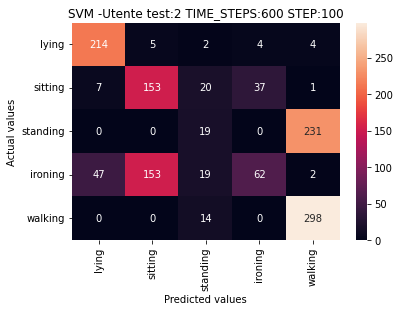

[LibSVM]              precision    recall  f1-score   support

     ironing       0.11      0.09      0.10       274
       lying       0.81      0.92      0.86       215
     sitting       0.26      0.29      0.28       282
    standing       0.53      0.71      0.61       200
     walking       0.99      0.65      0.78       280

    accuracy                           0.50      1251
   macro avg       0.54      0.53      0.53      1251
weighted avg       0.53      0.50      0.51      1251

f1 macro:  0.5267622553107577
f1 weighted:  0.5056305421147941
acc:  0.504396482813749


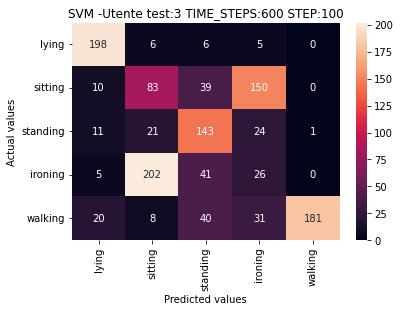

F1 weighted total:  0.5376217880462318
F1 macro total:  0.5428386479879914
Accuracy total:  0.5529845555276524
   Time Steps  Step  Average accuracy  Average F1 macro  Average F1 weighted
0         600   100          0.552985          0.542839             0.537622


In [62]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

svm_results = []

gc.collect()
for config in itertools.product(time_steps_list, step_list):

    time_step = config[0]
    step=config[1]

    tuple = tuple_by_timestep[time_steps][step]

    f1_macro_list = []
    f1_weighted_list = []
    acc_list = []

    for user_id in users_ids:

        x_test = tuple[user_id][0]
        y_test = tuple[user_id][1]

        x_train = []
        y_train = []

        for id in users_ids:
            if id != user_id:
                x_train+=tuple[id][0]
                y_train+=tuple[id][1]
        
        x_train = [x_train[i].flatten() for i in range(len(x_train)) ]
        x_test = [x_test[i].flatten() for i in range(len(x_test))]

        y_train = np.array(y_train).flatten()
        y_test = np.array(y_test).flatten()

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        #model = RandomForestClassifier(n_jobs=-1,n_estimators=1000,random_state=seed, verbose=True)
        model = SVC(kernel='linear',random_state=seed, verbose=1)

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        conf_mat = confusion_matrix(y_test, y_pred, labels=classes)

        f1_w = f1_score(y_test, y_pred, average='weighted')
        f1_m = f1_score(y_test, y_pred, average='macro')
        acc = accuracy_score(y_test, y_pred)

        print(classification_report(y_test, y_pred))

        ax = seaborn.heatmap(conf_mat, annot=True, fmt='d')

        ax.set_title("SVM -Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))
        ax.get_figure().savefig(svm_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual values')

        ax.xaxis.set_ticklabels(classes, rotation=90)
        ax.yaxis.set_ticklabels(classes, rotation=0)


        print("f1 macro: ", f1_m)
        print("f1 weighted: ", f1_w)
        print("acc: ", acc)

        f1_macro_list.append(f1_m)
        f1_weighted_list.append(f1_w)
        acc_list.append(acc)


        plt.show()
    
    print("F1 weighted total: ", np.mean(f1_weighted_list))
    print("F1 macro total: ", np.mean(f1_macro_list))
    print("Accuracy total: ", np.mean(acc_list))

    svm_results.append({
    'Time Steps':time_step,
    'Step':step,
    'Average accuracy':np.mean(acc_list),
    'Average F1 macro': np.mean(f1_macro_list),
    'Average F1 weighted': np.mean(f1_weighted_list)
    })

svm_results_df = pd.DataFrame(svm_results)
svm_results_df.to_csv(svm_dir + result_filename)
print(svm_results_df)



In [63]:
svm_results_df

,Time Steps,Step,Average accuracy,Average F1 macro,Average F1 weighted
0,600,100,0.552985,0.542839,0.537622


In [64]:
print("F1 weighted total: ", np.mean(f1_weighted_list))
print("F1 macro total: ", np.mean(f1_macro_list))
print("Accuracy total: ", np.mean(acc_list))

F1 weighted total:  0.5376217880462318
F1 macro total:  0.5428386479879914
Accuracy total:  0.5529845555276524
